In [1]:
import numpy as np
import camb
from matplotlib import pyplot as plt
from scipy.misc import derivative
import time

### Problem 2

In [2]:
def get_spectrum(pars,lmax=3000):
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    return tt[2:]

In [4]:
def ndiff(fun,m):
    model = fun(m)
    n = len(model)
    k = len(m)
    derivs = np.empty([n,k])
    
    for i in range(k):    

        dx = np.zeros(k)
        dx[i] = m[i]*0.01

        derivs[:,i] = (fun(m+dx) - fun(m-dx))/(2*dx[i])
    return model, derivs

In [5]:
def update_lamda(lamda,success):
    if success:
        lamda=lamda/1.5
        if lamda<0.5:
            lamda=0
    else:
        if lamda==0:
            lamda=1
        else:
            lamda=lamda*1.5**2
    return lamda

In [6]:
def get_matrices(m,fun,y,Ninv):
    model,derivs=ndiff(fun,m)
    model = model[:len(y)]
    derivs = derivs[:len(y),:]
    r=y-model
    lhs=derivs.T@Ninv@derivs
    rhs=derivs.T@(Ninv@r)
    chisq=r.T@Ninv@r
    return chisq,lhs,rhs

In [7]:
def linv(mat,lamda):
    mat=mat+lamda*np.diag(np.diag(mat))
    return np.linalg.inv(mat)

In [8]:
def fit_lm_clean(m,fun,y,Ninv,chitol=0.01):
    lamda=1
    
    chisq,lhs,rhs=get_matrices(m,fun,y,Ninv)
    #print(chisq)
    tau = m[3]
    i=0
    while True:
        i+=1
        #print(m[3])
        
        lhs_inv=linv(lhs,lamda)
        dm=lhs_inv@rhs
        m = m+dm
        
        #print('m1',m)
        #print('tau : ',m[3])
        if m[3] < 0 or m[3] > 1:
            m[3]=tau
        #print('m2',m)
        
        chisq_new,lhs_new,rhs_new=get_matrices(m,fun,y,Ninv)

                
        if chisq_new<chisq:  

            if lamda==0:
                if (np.abs(chisq-chisq_new)<chitol):
                    return m, lhs
            chisq=chisq_new
            lhs=lhs_new
            rhs=rhs_new
            
            
            lamda=update_lamda(lamda,True)
            
        else:
            lamda=update_lamda(lamda,False)
        #if i >10 :
            #return m, lhs
        print('on iteration ',i,' chisq is ',chisq,' with step ',dm,' and lamda ',lamda)
    return m, lhs

In [9]:
planck=np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt',skiprows=1)
spec=planck[:,1]
errs=0.5*(planck[:,2]+planck[:,3])

pars=np.asarray([60,0.02,0.1,0.05,2.00e-9,1.0])
#pars=np.asarray([69, 0.022, 0.12, 0.06, 2.1e-9, 0.95])

N = np.eye(len(errs))*(errs)**2
Ninv = np.linalg.inv(N)

In [10]:
start = time.time()
m, pcov = fit_lm_clean(pars,get_spectrum,spec,Ninv)
stop = time.time()
print('time:',stop-start)

on iteration  1  chisq is  5105.98042369442  with step  [ 2.57678849e+00 -1.37203492e-03  5.17330833e-03  5.61394899e-03
 -2.10048960e-11 -1.48842398e-02]  and lamda  0.6666666666666666
on iteration  2  chisq is  3487.888011861477  with step  [ 2.14464477e+00  1.91915905e-04  3.90171847e-03 -2.71272711e-03
  1.15019441e-11  5.27636820e-03]  and lamda  0
on iteration  3  chisq is  3252.837707877956  with step  [ 1.10018641e+00  3.07247163e-03  1.23633296e-02  1.12923567e-01
  5.50556984e-10 -3.39634940e-02]  and lamda  0
on iteration  4  chisq is  2625.7799697806677  with step  [ 2.14517273e+00  4.56272046e-04 -3.11184783e-03 -8.35089651e-02
 -3.52093950e-10  1.42936953e-02]  and lamda  0
on iteration  5  chisq is  2576.15490129863  with step  [ 2.90528983e-01  1.69744780e-05 -6.95823877e-04  3.37328754e-03
  3.11586766e-11  2.42353367e-03]  and lamda  0
time: 413.8503420352936


In [11]:
cov_inv = linv(pcov,0)
error_param = np.sqrt(np.diag(cov_inv))

In [12]:
with open('planc_fit_param.txt', 'w') as f:
    for i in range(len(m)):
        string = 'param {} : {} +/- {} \n'.format(i,m[i],error_param[i])
        f.write(string)
f.close()

### Problem 3

In [13]:
def gauss_chisq(pars,y,noise):
    pred=get_spectrum(pars) #predicted value
    pred = pred[:len(y)]

    return np.sum (((y-pred)/noise)**2)

In [15]:
def mcmc(pars,cov_param,y,fun,noise,nstep=500):
    
    L =  np.linalg.cholesky(cov_inv)
    
    chi_cur=fun(pars,y,noise) # compute chi-square
    #print(chi_cur)
    
    npar=len(pars) #number of parameters
    chain=np.zeros([nstep,npar])
    chivec=np.zeros(nstep) # chi-square as fcn of time/steps
    for i in range(nstep):
        #print('i :',i)
        step = 0.3*np.diag(L)*np.random.rand(npar)
        #print('step : ',step)
        trial_pars=pars+step #param at new step
        
        #print('trial pars : ',trial_pars)
        trial_chisq=fun(trial_pars,y,noise) #compute chi-square for trial, i.e. at new step
        #print('trial chisq : ',trial_chisq)
        
        delta_chisq=trial_chisq-chi_cur # difference trial chi-square and previous chi-square
        #print('chi cur : ',chi_cur,'delta :',delta_chisq,'\n')
        
        if i%10 == 0:
            print('i :',i)
            print('chi cur :',chi_cur)
            print('trial pars :',trial_pars)
            print('trial chisq',trial_chisq)
            print('delta chisq :',delta_chisq)
        
        accept_prob=np.exp(-0.5*delta_chisq)
        accept=np.random.rand(1)<accept_prob
        if accept:
            pars=trial_pars
            chi_cur=trial_chisq
        chain[i,:]=pars
        chivec[i]=chi_cur
    return chain,chivec

In [16]:
start = time.time()
chain , chivec = mcmc(pars,pcov,spec,gauss_chisq,errs,nstep=750)
stop = time.time()
print('time:',stop-start)

i : 0
chi cur : 15267.937150261656
trial pars : [6.01020818e+01 2.00059650e-02 1.00067192e-01 5.83286152e-02
 2.00027854e-09 1.00050254e+00]
trial chisq 13311.291680413824
delta chisq : -1956.645469847832


<ipython-input-15-4bb45d68cdbf>:31: RuntimeWarning: overflow encountered in exp
  accept_prob=np.exp(-0.5*delta_chisq)


i : 10
chi cur : 8092.946643948517
trial pars : [6.21288718e+01 2.03068593e-02 1.00794569e-01 9.87922220e-02
 2.00607415e-09 1.00316259e+00]
trial chisq 7979.421553745534
delta chisq : -113.52509020298294
i : 20
chi cur : 7877.862117197645
trial pars : [6.27699221e+01 2.03762918e-02 1.00958814e-01 1.09824069e-01
 2.00834465e-09 1.00404888e+00]
trial chisq 8190.264342852677
delta chisq : 312.40222565503245
i : 30
chi cur : 7632.632544638791
trial pars : [6.30539773e+01 2.04234558e-02 1.01138643e-01 1.09115947e-01
 2.01015342e-09 1.00425841e+00]
trial chisq 7933.315180733332
delta chisq : 300.6826360945415
i : 40
chi cur : 7526.869714648138
trial pars : [6.33071935e+01 2.04567165e-02 1.01251985e-01 1.11705593e-01
 2.01320459e-09 1.00419224e+00]
trial chisq 7976.149687846306
delta chisq : 449.2799731981677
i : 50
chi cur : 7526.869714648138
trial pars : [6.34771123e+01 2.04327100e-02 1.01190402e-01 1.12314145e-01
 2.01315350e-09 1.00409653e+00]
trial chisq 7959.697017261634
delta chisq : 

i : 420
chi cur : 6756.940329412217
trial pars : [6.73043161e+01 2.08323872e-02 1.02673328e-01 1.16149248e-01
 2.02649676e-09 1.01032686e+00]
trial chisq 7206.4801129215975
delta chisq : 449.53978350938087
i : 430
chi cur : 6756.940329412217
trial pars : [6.71548710e+01 2.08148993e-02 1.02581591e-01 1.13531742e-01
 2.02602768e-09 1.01000643e+00]
trial chisq 6838.403211974223
delta chisq : 81.4628825620066
i : 440
chi cur : 6756.940329412217
trial pars : [6.70747565e+01 2.08313562e-02 1.02598242e-01 1.16851430e-01
 2.02658316e-09 1.01016162e+00]
trial chisq 7305.218829037582
delta chisq : 548.2784996253649
i : 450
chi cur : 6756.940329412217
trial pars : [6.71312731e+01 2.08226803e-02 1.02561752e-01 1.13431388e-01
 2.02576003e-09 1.01009983e+00]
trial chisq 6830.402385048881
delta chisq : 73.46205563666445
i : 460
chi cur : 6756.940329412217
trial pars : [6.72825199e+01 2.08350039e-02 1.02553292e-01 1.20842841e-01
 2.02625735e-09 1.01029376e+00]
trial chisq 7949.338255852792
delta chisq

In [18]:
param_chain=np.mean(chain,axis=0)
std_param = np.std(chain,axis=0)

In [32]:
#compute the value for dark energy and error 

h = param_chain[0]/100
err_h = std_param[0]/100

err_b = std_param[1]
err_c = std_param[2]

omega_b = param_chain[1]/h**2
omega_c = param_chain[2]/h**2

err_omega_b = np.sqrt((err_b/param_chain[1])**2 + (2*err_h/h)**2)*omega_b
err_omega_c = np.sqrt((err_c/param_chain[2])**2 + (2*err_h/h)**2)*omega_c

dark_energy  = 1 - omega_b - omega_c
err_dark_energy = np.sqrt((err_omega_b)**2 + (err_omega_c)**2)

In [23]:
with open('Q3_estimate_dark_energy.txt', 'w') as f:
    string = "estimate on the mean value of the dark energy : {} +/- {}".format(dark_energy,err_dark_energy)

    f.write(string)

In [24]:
chivec = np.array([chivec])
list_file = np.concatenate((chivec.T, chain),axis=1)

In [25]:
np.savetxt('planck_chain.txt',list_file)

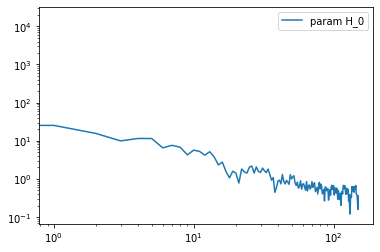

In [39]:
chainft = np.fft.rfft(chain[:,0])
plt.loglog(np.abs(chainft),label='param H_0')
plt.legend()
plt.savefig('0.pdf')
plt.show()

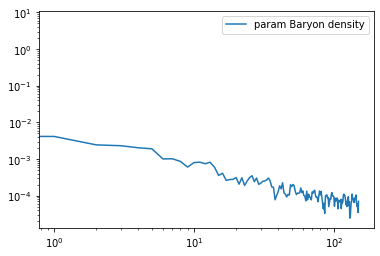

In [40]:
chainft = np.fft.rfft(chain[:,1])
plt.loglog(np.abs(chainft),label='param Baryon density')
plt.legend()
plt.savefig('1.pdf')
plt.show()

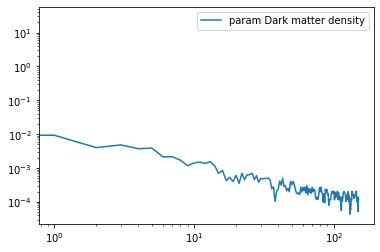

In [41]:
chainft = np.fft.rfft(chain[:,2])
plt.loglog(np.abs(chainft),label='param Dark matter density')
plt.legend()
plt.savefig('2.pdf')
plt.show()

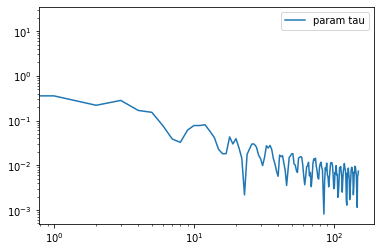

In [42]:
chainft = np.fft.rfft(chain[:,3])
plt.loglog(np.abs(chainft),label='param tau')
plt.legend()
plt.savefig('3.pdf')
plt.show()

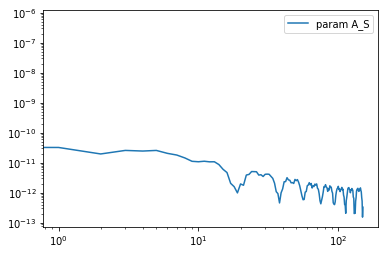

In [43]:
chainft = np.fft.rfft(chain[:,4])
plt.loglog(np.abs(chainft),label='param A_S')
plt.legend()
plt.savefig('4.pdf')
plt.show()

### Problem 4

In [27]:
def mcmc_tau(pars,cov_param,y,fun,noise,nstep=300):
    
    L =  np.linalg.cholesky(cov_inv)
    
    chi_cur=fun(pars,y,noise) # compute chi-square
    #print(chi_cur)
    
    npar=len(pars) #number of parameters
    chain=np.zeros([nstep,npar])
    chivec=np.zeros(nstep) # chi-square as fcn of time/steps
    for i in range(nstep):
        #print('i :',i)
        step = 0.2*np.diag(L)*np.random.rand(npar)
        #print('step : ',step)
        trial_pars=pars+step #param at new step
        trial_pars[3] = np.random.normal(0.054,0.0074) #normal distr for value of tau with mean 0.054 and std 0.0074
        
        #print('trial pars : ',trial_pars)
        trial_chisq=fun(trial_pars,y,noise) #compute chi-square for trial, i.e. at new step
        #print('trial chisq : ',trial_chisq)
        
        delta_chisq=trial_chisq-chi_cur # difference trial chi-square and previous chi-square
        #print('chi cur : ',chi_cur,'delta :',delta_chisq,'\n')
        
        accept_prob=np.exp(-0.5*delta_chisq)
        accept=np.random.rand(1)<accept_prob
        if accept:
            pars=trial_pars
            chi_cur=trial_chisq
        chain[i,:]=pars
        chivec[i]=chi_cur
    return chain,chivec

In [28]:
start = time.time()
chain , chivec = mcmc_tau(pars,pcov,spec,gauss_chisq,errs)
stop = time.time()
print('time:',stop-start)

<ipython-input-27-fcb1a2f73e83>:25: RuntimeWarning: overflow encountered in exp
  accept_prob=np.exp(-0.5*delta_chisq)


time: 1407.868891954422


In [31]:
param = np.mean(chain,axis=0)
print(param[3])

0.07087780270103204


In [17]:
def prior_chisq(pars,par_priors,par_errs):
    if par_priors is None:
        return 0
    par_shifts=pars-par_priors
    return np.sum((par_shifts/par_errs)**2)

In [ ]:
def mcmc_imp(pars,step_size,x,y,fun,nstep=300,noise=None,par_priors=None,par_errs=None):
    chi_cur=fun(pars,x,y,noise)+prior_chisq(pars,par_priors,par_errs)
    npar=len(pars)
    chain=np.zeros([nstep,npar])
    chivec=np.zeros(nstep)
    for i in range(nstep):
        trial_pars=pars+step_size*np.random.randn(npar)
        trial_chisq=fun(trial_pars,x,y,noise)+prior_chisq(pars,par_priors,par_errs)
        delta_chisq=trial_chisq-chi_cur
        accept_prob=np.exp(-0.5*delta_chisq)
        accept=np.random.rand(1)<accept_prob
        if accept:
            pars=trial_pars
            chi_cur=trial_chisq
        chain[i,:]=pars
        chivec[i]=chi_cur
    return chain,chivec